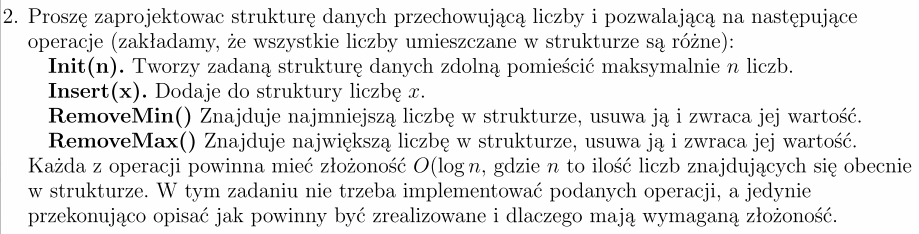

##### Funkcja pomocnicza formatująca kompletne drzewo binarne

In [2]:
def complete_tree_string(values):
    if values:
        just = 0
        data = []

        limit = 1
        values_row = []
        branches_row = []
        prev_nodes = 0

        for i in range(1, len(values) + 1):
            curr_nodes = i - prev_nodes
            val_str = str(values[i-1])
            just = max(just, len(val_str))
            values_row.append(val_str)
            right_child_idx = 2 * i
            left_child_idx = right_child_idx - 1
            if left_child_idx < len(values):
                branches_row.append('/')
            if right_child_idx < len(values):
                branches_row.append('\\')

            if curr_nodes == limit: 
                prev_nodes = i
                limit *= 2
                data.append([values_row, branches_row])
                values_row = []
                branches_row = []

        if values_row:
            data.append([values_row, branches_row])

        begin_sep = sep = 3 if just % 2 else 2
        data_iter = iter(data[::-1])
        result = [''] * (len(data) * 2 - 1)
        result[-1] = (' ' * sep).join(val.center(just) for val in next(data_iter)[0])

        # Format the tree string
        for i, (values, branches) in enumerate(data_iter):
            mul = 2 * i + 1
            # Values
            indent = (2 ** (i + 1) - 1) * (just + begin_sep) // 2
            sep = 2 * sep + just
            result[-(mul + 2)] = f"{' ' * indent}{(' ' * sep).join(val.center(just) for val in values)}"
            # Branches
            branch_indent = (3 * indent + just) // 4
            branches_row = []
            d_indent = indent - branch_indent
            branches_sep = ' ' * (2 * (d_indent - 1) + just)
            for i in range(0, len(branches), 2):
                branches_row.append(f"{branches[i]}{branches_sep}{branches[i + 1] if i + 1 < len(branches) else ''}")
            result[-(mul + 1)] = f"{' ' * branch_indent}{(' ' * (sep - 2 * d_indent)).join(branches_row)}"

        return '\n'.join(result)
    else:
        return ''

### Implementacja algorytmu

In [3]:
class CrazyHeap:
    def __init__(self, values=None):
        if values:
            # We make a copy of values in order not to modify them
            self.min_heap = [[i, values[i]] for i in range(len(values))]
            self.max_heap = [[i, values[i]] for i in range(len(values))]
            self.build_heaps()
        else:
            self.min_heap = []
            self.max_heap = []

    def __str__(self):
        max_str = complete_tree_string(self.max_heap)
        min_str = complete_tree_string(self.min_heap)
        return f"Max Heap:\n{max_str}\n\nMin Heap:\n{min_str}"

    def __bool__(self):
        return bool(self.max_heap)  # We can also use bool(self.min_heap)

    @property
    def heap_size(self):
        return len(self.max_heap)  # We can also use len(self.min_heap)

    @staticmethod
    def parent_idx(curr_idx):
        return (curr_idx - 1) // 2

    @staticmethod
    def left_child_idx(curr_idx):
        return curr_idx * 2 + 1

    @staticmethod
    def right_child_idx(curr_idx):
        return curr_idx * 2 + 2

    def get_max(self) -> object:
        return None if not self.max_heap else self.max_heap[0][1]

    def get_min(self) -> object:
        return None if not self.min_heap else self.min_heap[0][1]

    def insert(self, val: object):
        # Add values at the end of both heaps
        insert_idx = self.heap_size
        self.max_heap.append([insert_idx, val])
        self.min_heap.append([insert_idx, val])
        # If a value added is not lower than the greatest value previously stored,
        # fix only the Max Heap as the Min Heap wouldn't be violated
        if val >= self.get_max():
            self._heapify_max_up(insert_idx)
        # If a value is not greater than the lowest value previously stored,
        # fix only the Min Heap as the Max Heap wouldn't be violated
        elif val <= self.get_min():
            self._heapify_min_up(insert_idx)
        # If a value is between the greatest and the lowest value previously stored,
        # we have to fix both heaps
        else:
            self._heapify_max_up(insert_idx)
            self._heapify_min_up(insert_idx)

    def remove_max(self) -> object:
        if not self:
            raise IndexError(f'remove_max from an empty {self.__class__.__name__}')
        if self.heap_size == 1:
            removed = self.max_heap.pop()  # We can either pop it from the Max or from the Min Heap
            self.min_heap.clear()
        else:
            # Store removed entry (a root of the Max Heap)
            removed = self.max_heap[0]
            # Remove this entry from the Max Heap and fix indices stored in the Min Heap
            self.max_heap[0] = self.max_heap.pop()
            # Remove this entry from the Min Heap (it always will be one of leaves at index which
            # we have stored as the first value of the entry removed from the Max Heap)
            min_heap_last = self.min_heap[-1]
            # If we have to remove a leaf which is not the last one leaf of the Min Heap, we have
            # to fix indices stored in the Max Heap
            if min_heap_last is not self.min_heap[removed[0]]:
                self.min_heap[removed[0]] = min_heap_last
                # If the last node of the Min Heap wasn't the same as the last node of the Max Heap,
                # we can update index of a node of an index min_heap_last[0] to a proper value
                if min_heap_last[0] < len(self.max_heap):
                    self.max_heap[min_heap_last[0]][0] = removed[0]
                # Otherwise the node removed must be a root node, so we update an index stored by it
                else:
                    self.max_heap[0][0] = removed[0]
            # Fix indices stored in entries of the Min Heap which refer to the position of the
            # entry moved to a root position of the Max Heap (it was previously the last leaf)
            self.min_heap[self.max_heap[0][0]][0] = 0
            self.min_heap.pop()
            # Now we have to heapify down the Max Heap as we inserted a new node on the root position
            self._heapify_max_down(0, self.heap_size)
        return removed[1]  # Return only a value

    def remove_min(self) -> object:
        if not self:
            raise IndexError(f'remove_min from an empty {self.__class__.__name__}')
        if self.heap_size == 1:
            removed = self.max_heap.pop()  # We can either pop it from the Max or from the Min Heap
            self.min_heap.clear()
        else:
            # Store removed entry (a root of the Min Heap)
            removed = self.min_heap[0]
            # Remove this entry from the Min Heap and fix indices stored in the Max Heap
            self.min_heap[0] = self.min_heap.pop()
            # Remove this entry from the Max Heap (it always will be one of leaves an index of which
            # we have stored as the first value of the entry removed from the Min Heap)
            max_heap_last = self.max_heap[-1]
            # If we have to remove a leaf which is not the last one leaf of the Max Heap, we have
            # to fix indices stored in the Min Heap
            if max_heap_last is not self.max_heap[removed[0]]:
                self.max_heap[removed[0]] = max_heap_last
                # If the last node of the Max Heap wasn't the same as the last node of the Min Heap,
                # we can update index of a node of an index max_heap_last[0] to a proper value
                if max_heap_last[0] < len(self.min_heap):
                    self.min_heap[max_heap_last[0]][0] = removed[0]
                # Otherwise the node removed must be a root node, so we update an index stored by it
                else:
                    self.min_heap[0][0] = removed[0]
            # Fix indices stored in entries of the Max Heap which refer to the position of the
            # entry moved to a root position of the Min Heap (it was previously the last leaf)
            self.max_heap[self.min_heap[0][0]][0] = 0
            self.max_heap.pop()
            # Now we have to heapify down the Min Heap as we inserted a new node on the root position
            self._heapify_min_down(0, self.heap_size)
        return removed[1]  # Return only a value

    def swap(self, heap, i, j):
        # Swap nodes (both values and indices) in the heap specified
        heap[i], heap[j] = heap[j], heap[i]
        # Store indices which show where are swapped values stored in a second heap
        i = heap[i][0]
        j = heap[j][0]
        # Update indices stored in the second heap which wasn't modified
        if heap is self.max_heap:
            # Update entries (swap indices only) in the Min Heap
            self.min_heap[i][0], self.min_heap[j][0] = self.min_heap[j][0], self.min_heap[i][0]
        else:
            # Update entries (swap indices only) in the Max Heap
            self.max_heap[i][0], self.max_heap[j][0] = self.max_heap[j][0], self.max_heap[i][0]

    def build_heaps(self):
        self._build_max_heap()
        self._build_min_heap()
            
    def _heapify_max_up(self, curr_idx, end_idx=0):  # O(log n)
        while curr_idx > end_idx:
            parent_idx = self.parent_idx(curr_idx)
            # Compare values of the nodes
            if self.max_heap[curr_idx][1] > self.max_heap[parent_idx][1]:
                self.swap(self.max_heap, curr_idx, parent_idx)
            curr_idx = parent_idx

    def _heapify_min_up(self, curr_idx, end_idx=0):  # O(log n)
        while curr_idx > end_idx:
            parent_idx = self.parent_idx(curr_idx)
            # Compare values of the nodes
            if self.min_heap[curr_idx][1] < self.min_heap[parent_idx][1]:
                self.swap(self.min_heap, curr_idx, parent_idx)
            curr_idx = parent_idx

    def _heapify_max_down(self, curr_idx, end_idx):  # O(log n)
        # Loop till the current node has a child larger than itself
        # We assume that when we enter a node which both children are
        # smaller than this node, a subtree which a current node is a
        # root of must fulfill a max-heap property
        while True:
            l = self.left_child_idx(curr_idx)
            r = self.right_child_idx(curr_idx)
            largest_idx = curr_idx

            if l < end_idx:
                if self.max_heap[l][1] > self.max_heap[curr_idx][1]:
                    largest_idx = l
                if r < end_idx and self.max_heap[r][1] > self.max_heap[largest_idx][1]:
                    largest_idx = r

            if largest_idx != curr_idx:
                self.swap(self.max_heap, curr_idx, largest_idx)
                curr_idx = largest_idx
            else:
                break

    def _heapify_min_down(self, curr_idx, end_idx):  # O(log n)
        # Loop till the current node has a child smaller than itself
        # We assume that when we enter a node which both children are
        # larger than this node, a subtree which a current node is a
        # root of must fulfill a min-heap property
        while True:
            l = self.left_child_idx(curr_idx)
            r = self.right_child_idx(curr_idx)
            smallest_idx = curr_idx

            if l < end_idx:
                if self.min_heap[l][1] < self.min_heap[curr_idx][1]:
                    smallest_idx = l
                if r < end_idx and self.min_heap[r][1] < self.min_heap[smallest_idx][1]:
                    smallest_idx = r

            if smallest_idx != curr_idx:
                self.swap(self.min_heap, curr_idx, smallest_idx)
                curr_idx = smallest_idx
            else:
                break
                
    def _build_max_heap(self):   # O (n)
        for i in range(self.heap_size // 2 - 1, -1, -1):
            self._heapify_max_down(i, self.heap_size)
            
    def _build_min_heap(self):   # O (n)
        for i in range(self.heap_size // 2 - 1, -1, -1):
            self._heapify_min_down(i, self.heap_size)

###### Kilka testów

In [4]:
import random

lst = list(range(10))
random.shuffle(lst)
ch = CrazyHeap()
for i in lst:
    ch.insert(i)
    print(ch, end='\n\n\n\n')

print('Removing max:')
while ch:
    print(ch.remove_max(), end=' ')
print()
    
    
for i in lst:
    ch.insert(i)
print('Removing min:')
while ch:
#     print(ch)
    print(ch.remove_min(), end=' ')
print()

Max Heap:
[0, 8]

Min Heap:
[0, 8]



Max Heap:
    [1, 8]
    /    
[0, 7]

Min Heap:
    [1, 7]
    /    
[0, 8]



Max Heap:
    [1, 8]
    /    \
[2, 7]  [0, 6]

Min Heap:
    [2, 6]
    /    \
[0, 8]  [1, 7]



Max Heap:
            [3, 8]
          /        \
    [2, 7]          [1, 6]
    /    
[0, 2]

Min Heap:
            [3, 2]
          /        \
    [2, 6]          [1, 7]
    /    
[0, 8]



Max Heap:
            [3, 8]
          /        \
    [2, 7]          [4, 6]
    /    \
[1, 2]  [0, 1]

Min Heap:
            [4, 1]
          /        \
    [3, 2]          [1, 7]
    /    \
[0, 8]  [2, 6]



Max Heap:
            [5, 9]
          /        \
    [2, 7]          [3, 8]
    /    \          /    
[1, 2]  [0, 1]  [4, 6]

Min Heap:
            [4, 1]
          /        \
    [3, 2]          [1, 7]
    /    \          /    
[2, 8]  [5, 6]  [0, 9]



Max Heap:
            [5, 9]
          /        \
    [6, 7]          [3, 8]
    /    \          /    \
[1, 2]  [0, 1]  [4, 6]

In [5]:
import random

lst = list(range(7)) * 2
random.shuffle(lst)
ch = CrazyHeap(lst)

print(ch)

print('Removing min:')
while ch:
    print(ch.remove_min(), end=' ')
print()

Max Heap:
                                    [9, 6]
                            /                   \
                [8, 5]                                 [13, 6]
             /         \                             /         \
      [7, 4]              [3, 3]             [11, 2]              [6, 5]
     /     \             /     \             /     \             /     
 [1, 1]    [0, 0]    [4, 2]   [10, 3]    [2, 0]    [5, 1]   [12, 4]

Min Heap:
                                    [8, 0]
                            /                   \
                [7, 1]                                 [11, 0]
             /         \                             /         \
      [4, 3]              [9, 2]             [12, 1]              [6, 5]
     /     \             /     \             /     \             /     
 [3, 4]    [1, 5]    [0, 6]   [10, 3]    [5, 2]   [13, 4]    [2, 6]
Removing min:
0 0 1 1 2 2 3 3 4 4 5 5 6 6 
